In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 

### Paths

In [4]:
train_dir = "../data/processed/train"
val_dir = "../data/processed/val"
test_dir = "../data/processed/test"

### Loading datasets

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42 

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='int'
)

Found 14437 files belonging to 15 classes.
Found 3097 files belonging to 15 classes.
Found 3104 files belonging to 15 classes.


### Previewing Batch Images

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


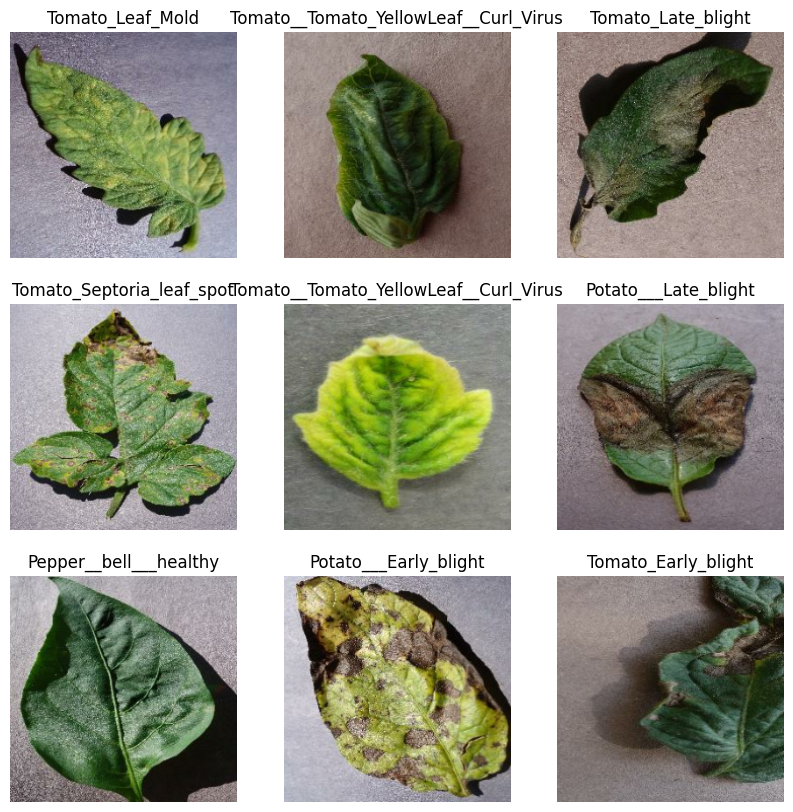

In [6]:
class_names = train_ds.class_names
print("Classes:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Dataset Preprocessing for Better Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

### Defining the baseline for the CNN Model

In [8]:
from tensorflow.keras import layers, models

# Model architecture
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


452/452 ━━━━━━━━━━━━━━━━━━━━ 399s 845ms/step - accuracy: 0.3374 - loss: 2.1020 - val_accuracy: 0.7317 - val_loss: 0.8834
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 344s 762ms/step - accuracy: 0.6597 - loss: 1.0381 - val_accuracy: 0.7827 - val_loss: 0.6896
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 363s 804ms/step - accuracy: 0.7323 - loss: 0.7995 - val_accuracy: 0.8240 - val_loss: 0.5504
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 343s 758ms/step - accuracy: 0.7859 - loss: 0.6297 - val_accuracy: 0.8744 - val_loss: 0.4066
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 351s 776ms/step - accuracy: 0.8190 - loss: 0.5252 - val_accuracy: 0.8431 - val_loss: 0.4751
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 339s 750ms/step - accuracy: 0.8346 - loss: 0.4819 - val_accuracy: 0.8650 - val_loss: 0.4357
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 343s 759ms/step - accuracy: 0.8647 - loss: 0.3931 - val_accuracy: 0.8844 - val_loss: 0.3496
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 346s 766ms/step - accuracy: 0.8737 - loss: 0.36

### Plotting Accuracy and Loss Curves

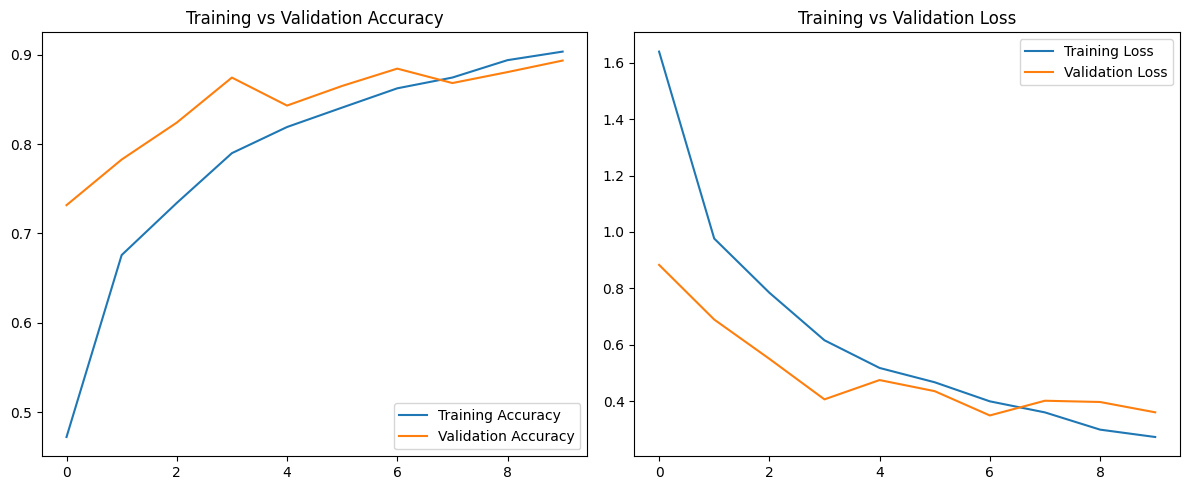

In [10]:

#Metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

### Evaluating the Model on the Test Set

In [11]:
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.8948 - loss: 0.3645

Test Accuracy: 0.8879
Test Loss: 0.3732


### Saving the Model

In [12]:
import os
import json

os.makedirs('models', exist_ok=True)

# Saving model in new Keras format
keras_model_path = 'models/plant_disease_detector_model.keras'
model.save(keras_model_path)  # Automatically uses the Keras format because of `.keras` extension

# Saving model info
model_info = {
    'class_names': class_names,
    'img_size': IMG_SIZE,
    'num_classes': len(class_names),
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss)
}

with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model saved in `.keras` format successfully!")
print(f"📁 Location: {keras_model_path}")
print(f"📊 Test Accuracy: {test_accuracy:.4f}")


✅ Model saved in `.keras` format successfully!
📁 Location: models/plant_disease_detector_model.keras
📊 Test Accuracy: 0.8879
